# <span style=" font-family: Calibri" > **Model Comparison and Tuning**

### <span style=" font-family: Calibri" > *Maya Dalton - PLSC 597 - 10/9/23*

<span style=" font-family: Calibri" > In this tutorial, I use data from my MA thesis to fine-tuning algorithms and evaluate the performance of a model. My data comes from the Varieties of Democracy (VDEM) dataset and Electoral Contention and Violence (ECAV) dataset. Using these two sources, the goal of my model is to predict electoral violence based on a handful of covariates: Gender Quota, Equal Protection Index, Regime Type, Electoral System, and actor/target types. I assess the performance of this model using different performance metrics, diagnose potential bias/variance issues with the model, and fine tune the parameters for optimizing the model. 
    
---

## 1. Load and Examine Data:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scipy
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv

import warnings
#warnings.filterwarnings('ignore')

In [2]:
# Import dataset - may need to change to your own pathway to load in
df = pd.read_csv('ecav_clean.csv')

# Rename Variables
df_c = df[["EventViolence", "v2lgqugen", "v2xeg_eqprotec", "regime_type", "v2elloelsy", "year", "Actor1Type", "Target1Type"]]
df_c = df_c.rename(columns={"v2lgqugen":"GenderQuota", "EventViolence":"ElectVio",
                          "v2xeg_eqprotec":"EqualProtInd", "regime_type":"Regime", "v2elloelsy":"ElectSys"})

# Let's take a look now...
print(df_c.head())

   ElectVio  GenderQuota  EqualProtInd  Regime  ElectSys  year  Actor1Type  \
0         1            0         0.612       5         6  1992           2   
1         1            0         0.612       5         6  1992           2   
2         1            0         0.612       5         6  1992           2   
3         1            0         0.612       5         6  1992           2   
4         0            0         0.612       0         5  1996           5   

   Target1Type  
0            1  
1            1  
2            1  
3            1  
4            1  


#### 1a. Exploratory Data Analysis

Text(0.5, 1.0, 'Election Violence Over Time')

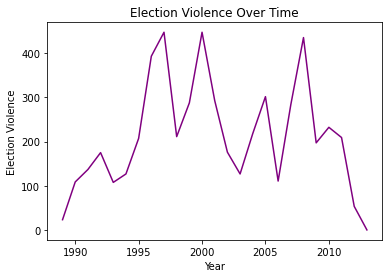

In [3]:
ev_sum = df_c.groupby('year')['ElectVio'].sum().reset_index()
plt.plot(ev_sum['year'], ev_sum['ElectVio'], linestyle='-', color="Purple")
plt.xlabel('Year')
plt.ylabel('Election Violence')
plt.title('Election Violence Over Time')

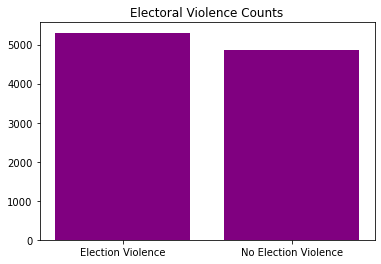

In [4]:
ev = len(np.argwhere(df_c.ElectVio.to_numpy()))
no_ev = len(df_c.ElectVio) - ev

plt.bar(['Election Violence', 'No Election Violence'],[ev, no_ev], color = 'purple')
plt.title('Electoral Violence Counts')
plt.show()

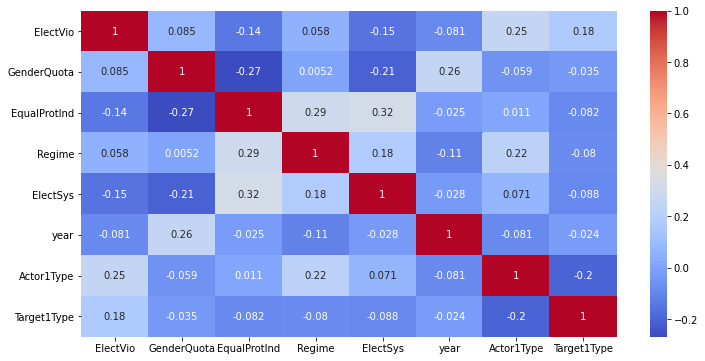

In [5]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_c.corr(), annot=True, cmap='coolwarm')
plt.show()

#### 1b. Now let's split our data:

In [3]:
# Separate features/predictors and target variable
X = df_c.drop('ElectVio', axis=1)  # drop EV only
y = df_c[['ElectVio']]  # keep EV only 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=918)

# Display the first few rows of the training and test sets for our predictors
print("Training Data:")
print(X_train.head())
print("\nTest Data:")
print(X_test.head()) 

Training Data:
      GenderQuota  EqualProtInd  Regime  ElectSys  year  Actor1Type  \
663             4         0.202       6         0  1991           1   
2850            4         0.190      -3         1  2010           2   
2721            0         0.203      -3         1  2005           1   
7936            0         0.593       3         5  2000           3   
2706            0         0.203      -3         1  2005           1   

      Target1Type  
663             2  
2850            1  
2721            2  
7936            3  
2706            3  

Test Data:
      GenderQuota  EqualProtInd  Regime  ElectSys  year  Actor1Type  \
6133            0         0.702       6         0  1999           2   
9655            0         0.693       6         0  1991           1   
1491            0         0.810       7         5  1990           2   
7149            0         0.638       4         0  2011           2   
6464            0         0.688      -7         7  1997           3   


## 2. Using pipelines for workflow

In [4]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression())])

In [5]:
y_train = np.ravel(y_train)
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.554


---
## 3. Using k-fold Cross Validation for Model Performance

In k-fold cross-validation, we randomly split the training dataset into k folds without replacement. Here, k – 1 folds, the so-called training folds, are used for the model training, and one fold, the so-called test fold, is used for performance evaluation. This procedure is repeated k times so that we obtain k models and performance estimates. This model has an accuracy of 56%.  

It's important to note that in each iteration I am using the training data alone to select hyperparameters. The test data is only used to make the final calculation of the performance after hyperparameter tuning. The test data is no longer test data if it is used to select hyperparameters.

In [9]:
# Using the training data for cross validation
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print(f'CV accuracy scores: {scores}')
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy scores: [0.52808989 0.55617978 0.56741573 0.56601124 0.59831461 0.5491573
 0.5625879  0.55977496 0.53867792 0.56118143]
CV accuracy: 0.559 +/- 0.018


---
## 4. Learning and Validation Curves

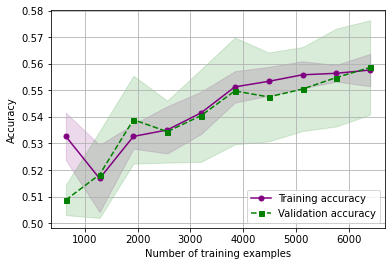

In [10]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1) 
test_mean = np.mean(test_scores, axis=1) 
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean, color='purple', marker='o', markersize=5, label='Training accuracy') 
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='purple') 

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy') 
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green') 
plt.grid()
plt.xlabel('Number of training examples') 
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

The learning curve above allows me to assess how the model may improve with an increased number of training examples. The model converges both the training and test datasets if it has seen more than 1000 training examples. The training accuracy increases for training datasets with fewer than 1000 examples, but the gap between validation and training accuracy increases with fewer examples, meaning an increasing degree of overfitting and high bias. 

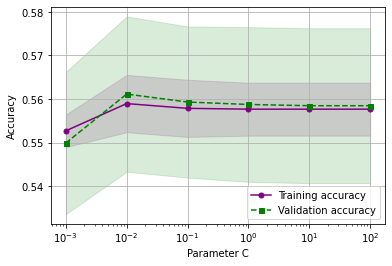

In [11]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1) 
test_mean = np.mean(test_scores, axis=1) 
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='purple', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='purple') 
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy') 
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green') 
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.show()

For the validation curve, I vary the values of the model parameters (inverse regularization parameter, C, in logistic regression) to assess under- or over-fitting of the model. One can see that the model tends to fit the data best when I decrease the regularization strength (large values of C). However, for small values of C, it means increasing the strength of regularization, so the model tends to overfit the data. In this case, the best value of C is around 100. 

---
## 5. Tuning via Grid Search

**What is a grid search?**

I specify a list of values for different hyperparameters, and the computer evaluates the model performance for each combination to obtain the optimal combination of values from this set. I can then improve the performance of a model by including the optimal combination of hyperparameter values.

### 5a. Complete Grid Search

I obtained the score of the best-performing model. In the case of my data, the RBF kernel SVM model with svc__C = 1.0 and svc__gamma=1.0 yielded the best k-fold cross-validation accuracy of 80.3%.

In [12]:
# Takes about 4 minutes to run...
# Make the SVC pipeline
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1)) 

# Set our hyperparameter ranges
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 

# Set up the grid for linear and kernel SVMs
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

# Conduct grid search
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=4,
                  refit=True,
                  n_jobs=-1) 

# Fit to training data
gs = gs.fit(X_train, y_train) 

print(gs.best_score_) 
print(gs.best_params_)

0.792158516020236
{'svc__C': 1.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}


In [13]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.796


Using the independent test dataset to estimate the performance of the best-selected model, I find that it performs with an accuracy of 79.6% which is significantly higher than the less optimized model from the basic pipeline fit.

### 5b. Randomized Grid Search

In [14]:
# Takes about 2 minutes to run...
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_range = scipy.stats.loguniform(0.0001, 1000.0)
np.random.seed(1)
param_range.rvs(10)

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs = rs.fit(X_train, y_train) 
print(rs.best_score_)
print(rs.best_params_)

0.7870966276331799
{'svc__C': 6.390082920230888, 'svc__gamma': 69.5632242450621, 'svc__kernel': 'rbf'}


In [17]:
clf = rs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.781


Using the independent test dataset to estimate the performance of the best-selected model, I find that the randomized grid search performs with an accuracy of 78.1% which is significantly higher than the less optimized model from the basic pipeline fit, but less accurate than the complete grid search.

<AxesSubplot:title={'center':'Complete Grid Search'}, xlabel='param_svc__gamma', ylabel='param_svc__C'>

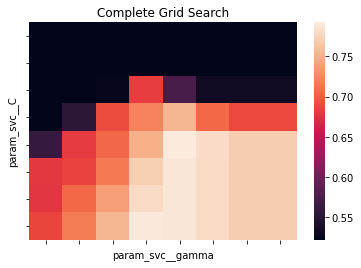

In [15]:
pvt_gs = pd.pivot_table(pd.DataFrame(gs.cv_results_),
    values='mean_test_score', index=['param_svc__C'], columns= 'param_svc__gamma')
p2 = sns.heatmap(pvt_gs, fmt='.3f')
p2.set(xticklabels=[]) 
p2.set(yticklabels=[]) 
plt.title('Complete Grid Search')
p2

<AxesSubplot:title={'center':'Randomized Search'}, xlabel='param_svc__gamma', ylabel='param_svc__C'>

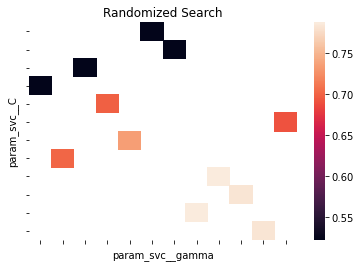

In [24]:
pvt_rs = pd.pivot_table(pd.DataFrame(rs.cv_results_),
    values='mean_test_score', index=['param_svc__C'], columns= 'param_svc__gamma')
p1 = sns.heatmap(pvt_rs, fmt='.3f')
p1.set(xticklabels=[]) 
p1.set(yticklabels=[]) 
plt.title('Randomized Search')
p1

The figures above depicts the comparison of grid search and randomized search for different hyperparameter configurations. One can see that the optimal hyperparameter setting is about a mean test score of 0.8 in both cases. In a complete grid search, the hyperparameters match up at lower gamma and C hyperparameters. For a randomized grid search, the gamma score becomes more inflated to optimize the hyperparameters. This is consistent with the accuracy score of the complete grid search performing slightly better than the randomized grid search. 

## 5c. Successive Halving Grid Search

Successive halving builds upon the randomized grid search. Given a large set of candidate configurations, the process successively throws out unpromising hyperparameter configurations until only one configuration remains. 

In [15]:
# Takes about a minute to run...
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_grid = {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['linear','rbf']}

hs = HalvingRandomSearchCV(pipe_svc,
                           param_distributions=param_grid,
                           n_candidates='exhaust',
                           resource='n_samples',
                           factor=1.5,
                           random_state=1,
                           n_jobs=-1)

hs = hs.fit(X_train, y_train) 

print(hs.best_score_)
print(hs.best_params_)

clf = hs.best_estimator_
print(f'Test accuracy: {hs.score(X_test, y_test):.3f}')

0.7828993086124122
{'svc__C': 9.189622130900707, 'svc__gamma': 0.1970088126798927, 'svc__kernel': 'rbf'}
Test accuracy: 0.779


Finally, I find that the successive halving grid search performs with an accuracy of 77.9% which is less accurate than both the compete and randomized grid searches. However, the accuracy of each is pretty close together, so if you want to cut down on computing time, you can use the successive halving search. 

## 5d. Nested Cross-Validation with Grid Search
If we want to select among different machine learning algorithms we can use nested cross-validation. Here, we have an outer k-fold cross-validation loop to split the data into training and test folds, and an inner loop is used to select the model using k-fold cross-validation on the training folds. After model selection, the test fold is then used to evaluate the model performance. To compare to the regular cross-validation from earlier, we use the complete grid search as the estimator rather than the pipeline.

In [20]:
# This takes about 4 min to run...
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.796 +/- 0.014


**Compared to a decision tree...**

In [21]:
gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}], 
    scoring='accuracy',
    cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)

print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.795 +/- 0.010


As we can see, the nested cross-validation performance of the SVM model (79.6%) using a complete grid search is barely better than the performance of the decision tree (79.5%).

---
## 6. Performance Evaluation Metrics

Assuming that class 1 (electoral violence) is the positive class in this example, my model correctly classified 1163 of the examples with no electoral violence and 1168 examples have electoral violence, respectively. However, my model also incorrectly misclassified 422 examples electoral violence as no electoral violence, and it predicted that 298 examples did not have instances of electoral violence although they had electoral violence (FP). 

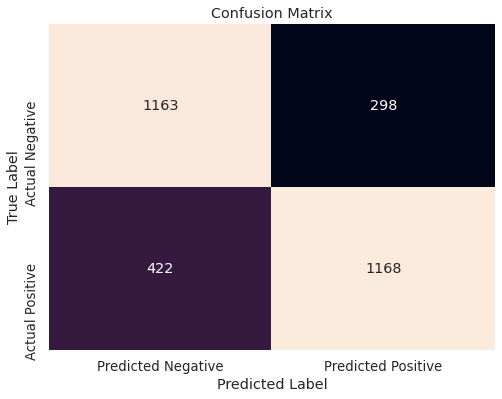

In [22]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confmat, annot=True, fmt='g', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [23]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

pre_val = precision_score(y_true=y_test, y_pred=y_pred) #prop of relevant values out of total # of true predictions
print(f'Precision: {pre_val:.3f}')

rec_val = recall_score(y_true=y_test, y_pred=y_pred) 
print(f'Recall: {rec_val:.3f}')
 
f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred) 
print(f'MCC: {mcc_val:.3f}')

Precision: 0.797
Recall: 0.735
F1: 0.764
MCC: 0.531


For precision, 79.7% of the observations that were positive in general (the sum of true and false positives) are actually relevant (true positives). For recall, 73.5% of the positive observations are captured as such. Across the entire dataset, the moddel made the correct predictions 76.4% of the time (the F1 score). Finally, the difference between the predicted values and actual values is 0.531, meaning it is a middle-ground model for recovering accurate scores. 

---
## 7. ROC Curve

I can also evaluate the performance of my model using an ROC curve and a precision-recall (PR) curve. The ROC curve shows the model performance with respect to the False Positive Rate and True Positive Rate. The PR curve shows the tradeoff between precision and recall for different thresholds, taking into account class imbalances. 

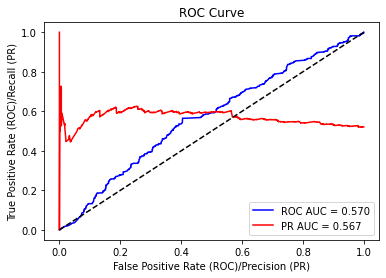

Area under the ROC curve: 0.57002
Area under the precision recall curve: 0.56707


In [7]:
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', C=100.0)
)
y_test = np.ravel(y_test)
pipe_lr.fit(X_train, y_train)

# Calculate ROC AUC
probs = pipe_lr.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Calculate PRC AUC
y_score = pipe_lr.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'ROC AUC = %0.3f' % roc_auc)
plt.plot(recall, precision, 'r', label = 'PR AUC = %0.3f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate (ROC)/Recall (PR)')
plt.xlabel('False Positive Rate (ROC)/Precision (PR)')
plt.show()

print(f'Area under the ROC curve: {roc_auc:.5f}')
print(f'Area under the precision recall curve: {pr_auc:.5f}')

As shown in the plot above, the black diagonal line can be interpreted as random guessing, and because the ROC curve is above this diagonal, I know that my model is better than random guessing. The PR curve shows that even when my precision increases, the true positive rate stays pretty much the same. So even when the classifier is returning accurate results (high precision), the amount of positive results is consistent. 

I also calculate the area under the curve (AUC) for both the ROC and PR curves. Whereas the ROC AUC looks at a true positive rate and false positive rate, PR AUC looks at the true positive rate (recall) and positive predictive value (precision). The accuracy of the model is 0.57 for the ROC, and 0.567 for the PR. This means that the model is okay at predicting overall, even when considering class imbalances. 

# <span style=" font-family: Calibri" > **Thank you!**